In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import r2_score
import pickle


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')
df['#stm_sap_meldnr'].sort_index(inplace = True)
df.drop_duplicates(subset = '#stm_sap_meldnr', keep = 'last',inplace = True)

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pd.set_option('display.max_rows', df.shape[0]+1) #max aantal rows 

In [4]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [5]:
def create_dummies(target_df, source_df, column):
    
    return target_df.join(pd.get_dummies(source_df.iloc[target_df.index][column]))

In [6]:
def get_accuracy(r,zip_list):
    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [7]:
# we willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.stm_fh_duur <= 480)]


# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df.copy()['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

# join de goetrajectcodes
geo_df = pd.read_csv('geocodes.csv',sep = ';') 
geo_df = geo_df.rename(columns={'Code': 'stm_geo_mld'})
df = df.merge(geo_df, on = 'stm_geo_mld', how = 'outer') 

# join de Contractgebiedcodes
cg = pd.read_excel('Contractgebiedcodes.xlsx') 
cg = cg.rename(columns={'Code': 'stm_contractgeb_gst'})
df = df.merge(cg, on = 'stm_contractgeb_gst', how = 'outer') 

# join de techniekvelden
tgv_df = pd.read_csv('techniekvelden.csv', sep = ';')
tgv_df = tgv_df.rename(columns={'Letter': 'stm_techn_mld'})
df = df.merge(tgv_df, on = 'stm_techn_mld', how = 'outer') 

# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 5
bins = [x for x in range(0,481,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)

error_margin1  = 5
bins1 = [x for x in range(0,481,error_margin1)]
labels1 = [x for x in range(1,len(bins1))]
df['duration_bin_reactie'] = pd.cut(df['stm_reactie_duur'], bins = bins1, labels=labels1)


# kolom voor meltijd h
df['meldtijd_h'] = df.stm_sap_meldtijd.str.split(':').str[0]


# maak een kolom voor weeknummers van de melding
df['weeknr']= df.stm_sap_melddatum.dt.isocalendar().week.apply(lambda x: 'w' + str(x))

In [8]:
df[['stm_techn_mld','Techniekveld OH plangroep']].value_counts()

stm_techn_mld  Techniekveld OH plangroep
S              Seinwezen                    104352
B              Baan                          67838
P              Post 21                       38362
T              Telecom                       33485
E              Energievoorziening            22688
K              Kunstwerken                   15779
O              Operationeel beheer           10082
G              Gebouwen                       2718
M              MR                             1961
I              Ondergrondse infra              321
X              Onbekend                        252
A              ATM                              76
dtype: int64

In [9]:
pd.set_option('display.max_rows', None)

In [10]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='stm_reactie_duur', ylabel='Density'>

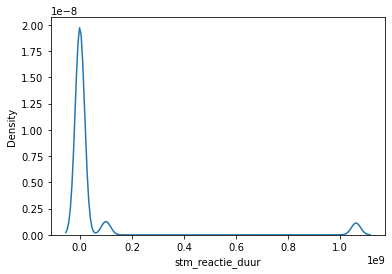

In [11]:
sns.kdeplot(df.stm_reactie_duur)

In [12]:
mean_durgeo_df = column_outlier('a', df.copy(), ['stm_reactie_duur'])[['stm_reactie_duur', 'Traject']].groupby('Traject', as_index = False).mean()
mean_durgeo_df

,Traject,stm_reactie_duur
0,Aachen (D) - Herzogenrath (D),NaN
1,Alkmaar,9.702128
2,Alkmaar - Uitgeest,32.571429
3,Almelo,53.555556
4,Almelo - Hengelo,22.000000
5,Almelo Dollegoor,NaN
6,Almelo Gem. Stamlijn,NaN
7,Alphen a/d Rijn,40.000000
8,Alphen a/d Rijn - Leiden Centraal,49.142857
9,Alphen a/d Rijn Industrieterrein Rijnhaven,NaN


<AxesSubplot:xlabel='stm_reactie_duur', ylabel='Contractgebied'>

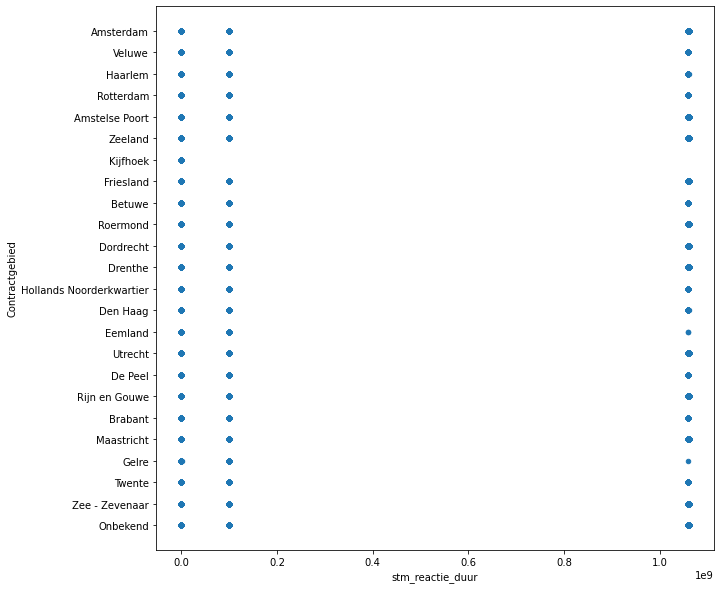

In [13]:
x = 'stm_reactie_duur'
y = 'Contractgebied'

tplot = df.sample(300000)[[x, y]]
tplot.sort_values(['stm_reactie_duur'], ascending=True, inplace=True)
tplot.dropna(inplace=True)

tplot.plot(x=x, y=y, kind='scatter',figsize=(10,10))

C:\Users\emiel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-14-d63c207f4a1f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")


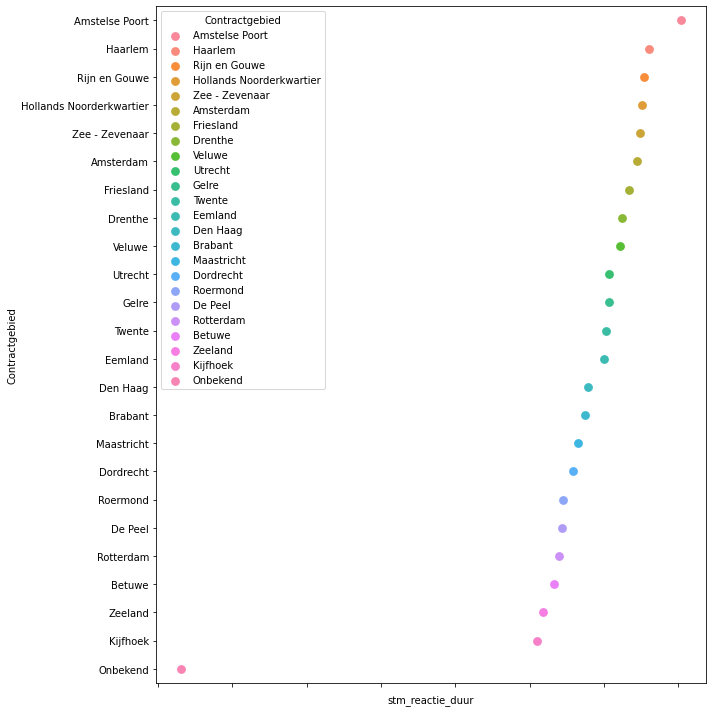

In [14]:
mean_cg_df = column_outlier('a', df.copy(), ['stm_reactie_duur'])[['stm_reactie_duur', 'Contractgebied']].groupby('Contractgebied', as_index = False).mean()
plt.figure(figsize=(10,10))
new_data= mean_cg_df.sort_values(by ='stm_reactie_duur' , ascending=False)
new_data_sort=new_data
ax=sns.pointplot(new_data_sort['stm_reactie_duur'], new_data_sort['Contractgebied'], hue=new_data_sort['Contractgebied'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")
plt.tight_layout()
plt.show()


In [15]:
df[df.columns[1:]].corr()['stm_fh_duur'][:]

#stm_sap_meldnr              0.005773
stm_mon_nr                   0.017230
stm_geo_mld_uit_functiepl   -0.030343
stm_equipm_nr_mld           -0.049695
stm_km_van_mld               0.007528
stm_km_tot_mld               0.028076
stm_prioriteit               0.142124
stm_mon_nr__statuscode       0.011634
stm_geo_gst_uit_functiepl   -0.020571
stm_equipm_nr_gst           -0.013051
stm_km_van_gst               0.021245
stm_km_tot_gst               0.026963
stm_oorz_code               -0.103402
stm_fh_status               -0.119846
stm_tao_telling_mutatie     -0.017077
stm_contractgeb_mld         -0.182659
stm_contractgeb_gst         -0.160130
stm_arbeid                  -0.056707
stm_progfh_in_duur          -0.196983
stm_progfh_gw_lwd_datum      0.075430
stm_progfh_gw_teller         0.112955
stm_fh_duur                  1.000000
stm_reactie_duur            -0.021064
stm_status_sapnaarmon        0.011485
stm_schadenr                 0.006441
stm_rapportage_maand         0.002086
stm_rapporta

In [16]:
mean_durgeo_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'stm_prioriteit']].groupby('stm_prioriteit', as_index = False).mean()
mean_durgeo_df

,stm_prioriteit,stm_fh_duur
0,1.0,100.071181
1,2.0,88.363253
2,4.0,77.813710
3,5.0,125.300643
4,8.0,87.918367
5,9.0,45.512714


In [17]:
df.stm_prioriteit.value_counts()
df.stm_prioriteit = df['stm_prioriteit'].dropna()           

In [18]:

df['stm_prioriteit_n'] = df['stm_prioriteit'].apply(lambda x: 1 if x in (1.0,2.0) else (2 if x in (4.0,5.0) else (3 if x == 8.0 else 4)))

In [19]:
df.stm_prioriteit_n.value_counts()

2    206606
1    150539
4      5328
3      2962
Name: stm_prioriteit_n, dtype: int64

<h2> MODEL COMPARISON </h2>

In [20]:
dt_df1 = df.copy()[['duration_bin_reactie', 'stm_km_tot_mld', 'stm_km_van_mld']].dropna()
dt_df1 = create_dummies(dt_df1,df,['Traject','meldtijd_h','stm_equipm_soort_mld', 'weeknr', 'stm_techn_mld', 'Oorzaak'])
dt_df1 = dt_df1.dropna()

X1 = dt_df1.drop(columns = ['duration_bin_reactie'])
y1 = dt_df1['duration_bin_reactie']

X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(X1, y1, test_size=0.2)
clf1 = DecisionTreeClassifier(max_depth = 13, random_state = 0).fit(X_train_db, y_train_db)

filename = 'Trained_ML_algorithms/decision_tree_duration_bin_reactie.sav'
pickle.dump(clf1, open(filename, 'wb'))



y_pred_db = clf1.predict(X_test_db)

accuracy_score(y_test_db,y_pred_db)

# predict_proba(X, check_input=True)[source]


0.20664380760640474

In [21]:
dt_df = df.copy()[['duration_bin', 'stm_reactie_duur', 'stm_prioriteit_n','stm_km_van_mld', 'stm_km_tot_mld']].dropna()

    
dt_df = create_dummies(dt_df,df,['Traject','meldtijd_h','stm_equipm_soort_mld', 'weeknr','Oorzaak','stm_vl_post'])

dt_df = dt_df.dropna()
    
# df.stm_fh_status = df.stm_fh_status.apply(lambda x: f"status: {x}")
# dt_df = create_dummies(dt_df,df,['stm_fh_status'])

X = dt_df.drop(columns = ['duration_bin'])
y = dt_df['duration_bin']

# clf = DecisionTreeClassifier(max_depth = 13, random_state = 0)


X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state = 0)

# c = GridSearchCV(DecisionTreeClassifier(random_state = 0), {'max_depth' : [22,32,42]})
# clf = c.fit(X_train_dt, y_train_dt)

clf = DecisionTreeClassifier(max_depth = 11, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)

# # from sklearn.model_selection import cross_val_score
y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]

filename = 'Trained_ML_algorithms/decision_tree.sav'
pickle.dump(clf, open(filename, 'wb'))

accuracy_score(y_test_dt,y_pred_dt)

# scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
#0.1519

0.15210369275409927

In [22]:
# corrMatrix = dt_df1.corr()
# corrMatrix

In [23]:
# sns.set(rc = {'figure.figsize':(30,10)})
# sns.heatmap(corrMatrix, annot=True)


In [24]:
# corrMatrix.boxplot(figsize=(30,10))

In [25]:
dt_df2 = df.copy()[['duration_bin','stm_reactie_duur','stm_prioriteit']].dropna()

    
dt_df2 = create_dummies(dt_df2,df,['weeknr','Oorzaak', 'Contractgebied'])

dt_df2 = dt_df2.dropna()
    

X2 = dt_df2.drop(columns = ['duration_bin'])
y2 = dt_df2['duration_bin']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X2, y2, test_size=0.2, random_state = 0)

clf3 = DecisionTreeClassifier(random_state = 0, min_samples_leaf = 75, max_depth = 13)
clf3.fit(X_train_f.values, y_train_f)

y_pred_f = clf3.predict(X_test_f)
filename = 'Trained_ML_algorithms/mini_decision_tree.sav'
pickle.dump(clf3, open(filename, 'wb'))

y4_ax = [get_accuracy(x, list(zip(list(y_test_f), y_pred_f))) for x in range(0,30)]
accuracy_score(y_test_f,y_pred_f)
#0.1487192138481148

0.15247833764527124

In [26]:
df.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind,date_offset,seizoen_melding,spring,summer,autumn,winter,Oorzaak,Traject,Contractgebied,Techniekveld OH plangroep,duration_bin,duration_bin_reactie,meldtijd_h,weeknr,stm_prioriteit_n
0,2,50053213.0,48.0,GN,02/01/2006 12:35:00,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-Post: ...,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-P,NaN,NaN,201.0,201.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS,Aan AM toegewezen,0.0,03/01/2006,02/01/2006 12:35:00,NaN,37B,201.0,201.0,NaN,NaN,NaN,NaN,NaN,30200.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-DERD,143.0,NaN,ONREGDER,T,NaN,NaN,NaN,02/01/2006 13:26:00,4.0,02/01/2006 13:26:00,NaN,NaN,N,NaN,NaN,0.0,NB,"0,00",NaN,03/01/2006,05:50:40,2006-02-01,12:35:00,02/01/2006,12:35:00,NaN,201,NaN,37.0,201,B,02/01/2006,12:35:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,13:26:00,51.0,99999999.0,02/01/2006,13:26:00,NaN,NaN,10/01/2006,J,1.0,N,J,05/01/2009 15:10:11,05/01/2009,15:10:11,02/01/2006 05:50:40,0.85,NaN,NaN,IN0 H5,0000000000,NaN,schapen op de spoorbaan!,NaN,NaN,0.0,NaN,0.0,NaN,NaN,50053213.0,NaN,NaN,Lp,Apg,00/00/0000,00:00:00,NaN,1.0,2006.0,02/01/2006 12:35:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1.0,1518.0,12704591.0,13/06/2013 13:37:52,0.0,1181.0,winter,0.0,0.0,0.0,1.0,"Dieren, schade door of (bijna) aanrijding",NaN,Friesland,NaN,11,NaN,12,w5,4
1,3872,50059285.0,10216.0,GN,24/10/2

In [27]:
set(list(df.Contractgebied))

{'Amstelse Poort',
 'Amsterdam',
 'Betuwe',
 'Brabant',
 'De Peel',
 'Den Haag',
 'Dordrecht',
 'Drenthe',
 'Eemland',
 'Friesland',
 'Gelre',
 'Haarlem',
 'Hollands Noorderkwartier',
 'Kijfhoek',
 'Maastricht',
 'Onbekend',
 'Rijn en Gouwe',
 'Roermond',
 'Rotterdam',
 'Twente',
 'Utrecht',
 'Veluwe',
 'Zee - Zevenaar',
 'Zeeland',
 nan}

In [28]:
y_train_f.head()

80615     27
29796     13
178991    40
320397    83
362479    10
Name: duration_bin, dtype: category
Categories (96, int64): [1 < 2 < 3 < 4 ... 93 < 94 < 95 < 96]

In [29]:
text_representation = tree.export_text(clf3)
print(text_representation)

|--- feature_0 <= 14.50
|   |--- feature_0 <= 7.50
|   |   |--- feature_0 <= 4.50
|   |   |   |--- feature_74 <= 0.50
|   |   |   |   |--- feature_89 <= 0.50
|   |   |   |   |   |--- feature_127 <= 0.50
|   |   |   |   |   |   |--- feature_57 <= 0.50
|   |   |   |   |   |   |   |--- feature_139 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_126 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_142 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_129 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_129 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- feature_142 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- 

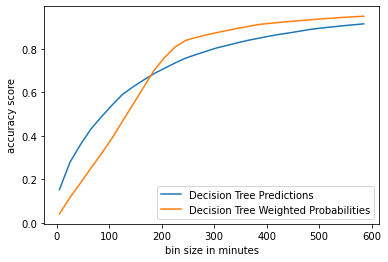

,probability_bin,pred_bin,actual_bin,prob_bin_error,pred_bin_error
count,73053.000000,73053.000000,73053.000000,73053.000000,73053.000000
mean,22.890080,13.625341,22.901633,9.173887,9.857405
std,15.093877,15.871928,20.429440,10.224357,13.951371
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,13.000000,2.000000,8.000000,3.000000,1.000000
50%,20.000000,9.000000,17.000000,7.000000,5.000000
75%,27.000000,17.000000,31.000000,10.000000,12.000000
max,95.000000,96.000000,96.000000,86.000000,95.000000


In [30]:
def get_weighted_prob_bin(prob_list):
    
    return round(sum([(count+1) * i for count,i in enumerate(prob_list)]))



prob_df = pd.DataFrame({'probability_bin':[get_weighted_prob_bin(i) for i in clf3.predict_proba(X_test_f)], 'pred_bin':clf3.predict(X_test_f), 'actual_bin':y_test_f})
prob_df = prob_df.astype('int')

prob_df['prob_bin_error'] = abs(prob_df['probability_bin'] - prob_df['actual_bin'])
prob_df['pred_bin_error'] = abs(prob_df['pred_bin'] - prob_df['actual_bin'])


pred_accs = [get_accuracy(i, list(zip(prob_df.pred_bin,prob_df.actual_bin))) for i in range(30)]
prob_accs = [get_accuracy(i, list(zip(prob_df.probability_bin,prob_df.actual_bin))) for i in range(30)]


x_ax = [error_margin +(20*x) for x in range(0,30)]


plt.plot(x_ax,pred_accs, label = 'Decision Tree Predictions')
plt.plot(x_ax,prob_accs, label = 'Decision Tree Weighted Probabilities')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()
prob_df.describe()



In [31]:
df = df[df.meldtijd_h != ""]

In [32]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld','spring', 'summer','autumn','winter','stm_oorz_code','stm_contractgeb_gst']].dropna()

X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin

X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 13).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)

y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]

accuracy_score(y_test_kn,y_pred_kn)



0.07492515988569873

In [33]:
# vergelijk prorail prognose van hersteltijd met daadwerkelijke hersteltijd
bins = [x for x in range(0,481,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]

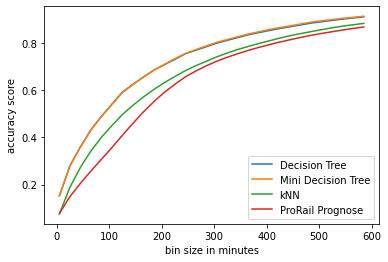

In [34]:
x_ax = [error_margin +(20*x) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y4_ax, label = 'Mini Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()


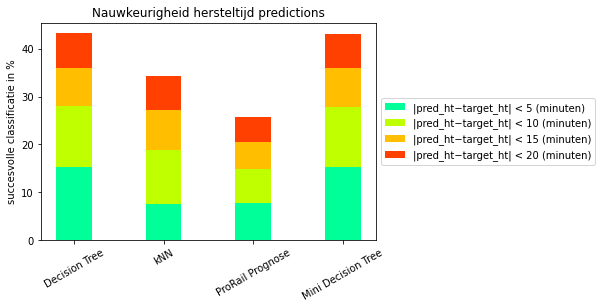

In [35]:
labels = ['Decision Tree','kNN', 'ProRail Prognose', 'Mini Decision Tree']

bar_1 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
bar_2 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
bar_3 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]
bar_4 = [100 * (eval(f"y{i}_ax[3]") - eval(f"y{i}_ax[2]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, bar_1, width, label=f'|pred_ht−target_ht| < {error_margin} (minuten)', color = '#00ff99')
ax.bar(labels, bar_2, width ,bottom=bar_1,label=f'|pred_ht−target_ht| < {2*error_margin} (minuten)', color = '#bfff00')
ax.bar(labels, bar_3, width ,bottom=(np.array(bar_2) + np.array(bar_1)),label=f'|pred_ht−target_ht| < {3*error_margin} (minuten)', color = '#ffbf00')
ax.bar(labels, bar_4, width ,bottom=(np.array(bar_2) + np.array(bar_1) + np.array(bar_3)),label=f'|pred_ht−target_ht| < {4*error_margin} (minuten)', color = '#ff4000')


ax.set_ylabel('succesvolle classificatie in %')
ax.set_title('Nauwkeurigheid hersteltijd predictions')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [36]:
list(X_train_dt.columns)

['stm_reactie_duur',
 'stm_prioriteit_n',
 'stm_km_van_mld',
 'stm_km_tot_mld',
 'Traject_Alkmaar',
 'Traject_Alkmaar - Uitgeest',
 'Traject_Almelo',
 'Traject_Almelo - Hengelo',
 'Traject_Alphen a/d Rijn',
 'Traject_Alphen a/d Rijn - Leiden Centraal',
 'Traject_Amersfoort',
 'Traject_Amersfoort - Amersfoort Aansl.',
 'Traject_Amersfoort Aansl.',
 'Traject_Amersfoort Aansl. - Barneveld Noord',
 'Traject_Amersfoort Aansl. - Hattemerbroek',
 'Traject_Amersfoort Bokkeduinen',
 'Traject_Amersfoort Hoofdwerkplaats',
 'Traject_Amsterdam Bijlmer - Nieuwersluis-Loenen',
 'Traject_Amsterdam Bijlmer Arena',
 'Traject_Amsterdam Centraal',
 'Traject_Amsterdam Dijksgracht',
 'Traject_Amsterdam Hemhaven (gebied)',
 'Traject_Amsterdam Houtrakpolder (gebied)',
 'Traject_Amsterdam Lijnwerkplaats',
 'Traject_Amsterdam Muiderpoort',
 'Traject_Amsterdam Muiderpoort - Diemen',
 'Traject_Amsterdam Muiderpoort - Duivendrecht',
 'Traject_Amsterdam Riekerpolder',
 'Traject_Amsterdam Riekerpolder - Warmond',
 '

In [37]:
list(X_train_kn.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'spring',
 'summer',
 'autumn',
 'winter',
 'stm_oorz_code',
 'stm_contractgeb_gst']

In [38]:
list(X_train_f.columns)

['stm_reactie_duur',
 'stm_prioriteit',
 'weeknr_w1',
 'weeknr_w10',
 'weeknr_w11',
 'weeknr_w12',
 'weeknr_w13',
 'weeknr_w14',
 'weeknr_w15',
 'weeknr_w16',
 'weeknr_w17',
 'weeknr_w18',
 'weeknr_w19',
 'weeknr_w2',
 'weeknr_w20',
 'weeknr_w21',
 'weeknr_w22',
 'weeknr_w23',
 'weeknr_w24',
 'weeknr_w25',
 'weeknr_w26',
 'weeknr_w27',
 'weeknr_w28',
 'weeknr_w29',
 'weeknr_w3',
 'weeknr_w30',
 'weeknr_w31',
 'weeknr_w32',
 'weeknr_w33',
 'weeknr_w34',
 'weeknr_w35',
 'weeknr_w36',
 'weeknr_w37',
 'weeknr_w38',
 'weeknr_w39',
 'weeknr_w4',
 'weeknr_w40',
 'weeknr_w41',
 'weeknr_w42',
 'weeknr_w43',
 'weeknr_w44',
 'weeknr_w45',
 'weeknr_w46',
 'weeknr_w47',
 'weeknr_w48',
 'weeknr_w49',
 'weeknr_w5',
 'weeknr_w50',
 'weeknr_w51',
 'weeknr_w52',
 'weeknr_w53',
 'weeknr_w6',
 'weeknr_w7',
 'weeknr_w8',
 'weeknr_w9',
 'Oorzaak_Aanrijding (bijna) tijdens werkzaamheden',
 'Oorzaak_Afstelling onjuist/verlopen',
 'Oorzaak_Applicatie/softwarefout',
 'Oorzaak_Belemmerende vegetatie',
 'Oorzaak_

In [39]:
# base chance for a right classification by guessing the most common bin
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

0.05047266793879546

In [40]:
# decision tree
[y1_ax[0],y1_ax[1],y1_ax[2]]

[0.15210369275409927, 0.27984451561687335, 0.3600093071637787]

In [41]:
# kNN
[y2_ax[0],y2_ax[1],y2_ax[2]]

[0.07492515988569873, 0.18823989658456933, 0.27280922574499933]

In [42]:
# prorail prognose
[y3_ax[0],y3_ax[1],y3_ax[2]]

[0.07688771952069993, 0.14848950738603944, 0.20462578456856653]

In [43]:
#mini decision tree
[y4_ax[0],y4_ax[1],y4_ax[2]]

[0.15247833764527124, 0.2782363489521306, 0.3593144703160719]

In [44]:
print(len(X_test_f)) ##mini decision tree

73053
